In [2]:
import numpy as np
import pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [13]:
train = pd.read_csv("train_data.csv") # 초기 자료
back_train = pd.read_csv("train_final1.csv") # 역번역 자료
test = pd.read_csv("test_data.csv") # test 초기 자료
back_test = pd.read_csv("test_final1.csv") # 역번역 자료

In [16]:
a=pd.DataFrame()
a["title"]=back_train["title_kor"]
a["index"]=back_train["index"]
a["topic_idx"]=back_train["topic_idx"]
b=pd.DataFrame()
b["title"]=train["title"]
b["index"]=train["index"]
b["topic_idx"]=train["topic_idx"]

In [17]:
train2=pd.concat([a,b])

In [18]:
X_train = np.array([x for x in train2['title']])
X_test = np.array([x for x in back_test['title_kor']])
Y_train = np.array([x for x in train2['topic_idx']])

In [19]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)

(91308,)
(9131,)
(91308,)


In [20]:
vocab_size = 5000 #2000~10000도 시도해봄

tokenizer = Tokenizer(num_words = vocab_size)
  # Tokenizer 는 데이터에 출현하는 모든 단어의 개수를 세고 빈도 수로 정렬해서
  # num_words 에 지정된 만큼만 숫자로 반환하고, 나머지는 0 으로 반환합니다
tokenizer.fit_on_texts(X_train) # Tokenizer 에 데이터 실제로 입력
sequences_train = tokenizer.texts_to_sequences(X_train)    # 문장 내 모든 단어를 시퀀스 번호로 변환
sequences_test = tokenizer.texts_to_sequences(X_test)      # 문장 내 모든 단어를 시퀀스 번호로 변환

print(len(sequences_train), len(sequences_test))

91308 9131


In [21]:
word_index = tokenizer.word_index

<ipython-input-22-4417c795de89>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tuple(dataframe.doc_len), hist=True, kde=True, label='Document lengths')


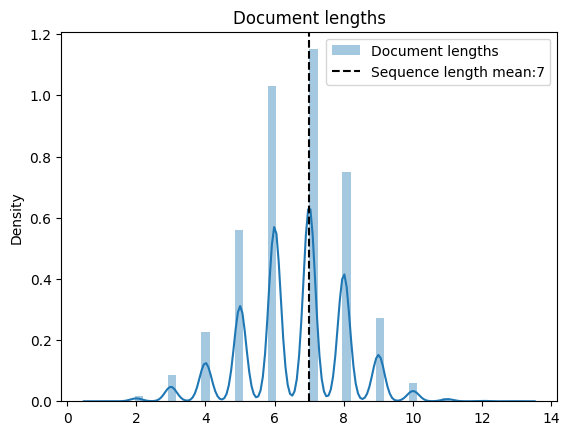

13


In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# 문장 길이 분포도 확인
train['doc_len'] = train.title.apply(lambda words: len(words.split()))

def plot_doc_lengths(dataframe):
    mean_seq_len = np.round(dataframe.doc_len.mean()).astype(int)
    sns.distplot(tuple(dataframe.doc_len), hist=True, kde=True, label='Document lengths')
    plt.axvline(x=mean_seq_len, color='k', linestyle='--', label=f'Sequence length mean:{mean_seq_len}')
    plt.title('Document lengths')
    plt.legend()
    plt.show()
    print(train['doc_len'].max())

plot_doc_lengths(train)

In [23]:
max_length = 14    # 위에서 그래프 확인 후 정함
padding_type='post'

train_X = pad_sequences(sequences_train, padding='post', maxlen=max_length)
test_X = pad_sequences(sequences_test, padding=padding_type, maxlen=max_length)

In [24]:
train_Y = np_utils.to_categorical(Y_train) # Y_train 에 원-핫 인코딩
print(train_Y)
print(train_Y.shape)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
(91308, 7)


In [25]:
#파라미터 설정
vocab_size = 5000 # 제일 많이 사용하는 사이즈
embedding_dim = 200
max_length = 14    # 위에서 그래프 확인 후 정함
padding_type='post'

In [26]:
model3 = Sequential([Embedding(vocab_size, embedding_dim, input_length =max_length),
        tf.keras.layers.Bidirectional(LSTM(units = 64, return_sequences = True)),
        tf.keras.layers.Bidirectional(LSTM(units = 64, return_sequences = True)),
        tf.keras.layers.Bidirectional(LSTM(units = 64)),
        Dense(7, activation='softmax')    # 결과값이 0~4 이므로 Dense(5)
    ])

model3.compile(loss= 'categorical_crossentropy', #여러개 정답 중 하나 맞추는 문제이므로 손실 함수는 categorical_crossentropy
              optimizer= 'adam',
              metrics = ['accuracy'])
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 14, 200)           1000000   
                                                                 
 bidirectional (Bidirectiona  (None, 14, 128)          135680    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 14, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 7)                 903       
                                                        

In [ ]:
# 모델 실행해보기
history = model3.fit(train_X, train_Y, epochs=30, batch_size=128, validation_split= 0.2)
  # 양방향 LSTM 레이어에서는 batch size 를 128으로 잡고 20~50회 학습 해보았다.

Epoch 1/30
571/571 [==============================] - 137s 215ms/step - loss: 0.8949 - accuracy: 0.6832 - val_loss: 0.6696 - val_accuracy: 0.7771
Epoch 2/30
571/571 [==============================] - 123s 215ms/step - loss: 0.6473 - accuracy: 0.7790 - val_loss: 0.6245 - val_accuracy: 0.7908
Epoch 3/30
571/571 [==============================] - 120s 211ms/step - loss: 0.5892 - accuracy: 0.7958 - val_loss: 0.6059 - val_accuracy: 0.7921
Epoch 4/30
571/571 [==============================] - 123s 216ms/step - loss: 0.5521 - accuracy: 0.8052 - val_loss: 0.6109 - val_accuracy: 0.7893
Epoch 5/30
571/571 [==============================] - 121s 212ms/step - loss: 0.5190 - accuracy: 0.8125 - val_loss: 0.6049 - val_accuracy: 0.7922
Epoch 6/30
571/571 [==============================] - 123s 216ms/step - loss: 0.4869 - accuracy: 0.8220 - val_loss: 0.6222 - val_accuracy: 0.7904
Epoch 7/30
571/571 [==============================] - 120s 211ms/step - loss: 0.4539 - accuracy: 0.8321 - val_loss: 0.6370 -

In [ ]:
# 계층 교차 검증
n_fold = 5
seed = 42

cv = StratifiedKFold(n_splits = n_fold, shuffle=True, random_state=seed)

# 테스트데이터의 예측값 담을 곳 생성
test_Y = np.zeros((test_X.shape[0], 7))

# 조기 종료 옵션 추가
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=4,
                   verbose=1, mode='min', baseline=None, restore_best_weights=True)

for i, (i_trn, i_val) in enumerate(cv.split(train_X, Y_train), 1):
    print(f'training model for CV #{i}')

    model3.fit(train_X[i_trn],
            to_categorical(Y_train[i_trn]),
            validation_data=(train_X[i_val], to_categorical(Y_train[i_val])),
            epochs=20,
            batch_size=256,
            callbacks=[es])     # 조기 종료 옵션

    test_Y += model3.predict(test_X) / n_fold    # 나온 예측값들을 교차 검증 횟수로 나눈다

In [ ]:
#각 topic으로 예측할 확률
test_Y

In [ ]:
topic = []
for i in range(len(test_Y)):
    topic.append(np.argmax(test_Y[i]))

In [ ]:
submission = pd.read_csv('sample_submission.csv')
submission['topic_idx'] = topic
submission

In [ ]:
submission.to_csv('LSTM_results.csv',index = False)